<a href="https://colab.research.google.com/github/nojiyoon/pytorch_basic/blob/main/03_%EC%84%B1%EB%8A%A5%ED%96%A5%EC%83%81%EA%B8%B0%EB%B2%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/makeyourownneuralnetwork/gan/blob/master/04_mnist_classifier_refinements.ipynb

# 데이터셋

In [38]:
!wget https://pjreddie.com/media/files/mnist_train.csv
!wget https://pjreddie.com/media/files/mnist_test.csv

--2021-06-11 08:02:04--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [application/octet-stream]
Saving to: ‘mnist_train.csv.1’

mnist_train.csv.1   100%[===================>] 104.50M  22.4MB/s    in 5.4s    

2021-06-11 08:02:10 (19.5 MB/s) - ‘mnist_train.csv.1’ saved [109575994/109575994]

--2021-06-11 08:02:11--  https://pjreddie.com/media/files/mnist_test.csv
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18289443 (17M) [application/octet-stream]
Saving to: ‘mnist_test.csv.1’

mnist_test.csv.1    100%[===================>]  17.44M  12.4MB/s    in 1.4s    

2021-06-11 08:02:13 (12.4 MB/s) - ‘mnist_test.csv.1’ saved [18289443/18289443]



In [39]:
import pandas

In [40]:
df = pandas.read_csv('mnist_train.csv', header=None)

In [41]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,147,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 359.3 MB


In [43]:
import matplotlib.pyplot as plt

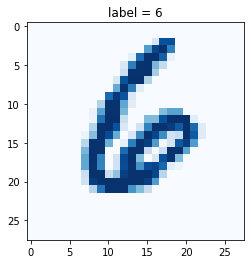

In [44]:
# 데이터프레임으로부터 데이터 할당
row = 13
data = df.iloc[row]

# 첫 번째 값은 레이블
label = data[0]

# 이미지 데이터는 나머지 784개의 값
img = data[1:].values.reshape(28,28)
plt.title("label = " + str(label))
plt.imshow(img, interpolation='none', cmap='Blues')
plt.show()

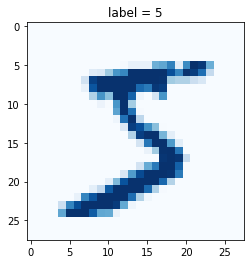

In [45]:
# get data from dataframe
row = 0
data = df.iloc[row]

# label in the first value
label = data[0]

# image data is the remaining 784 values
img = data[1:].values.reshape(28,28)
plt.title("label = " + str(label))
plt.imshow(img, interpolation='none', cmap='Blues')
plt.show()

# 간단한 신경망 / 훈련 시각화하기

In [46]:
import torch
import torch.nn as nn

In [94]:
class Classifier(nn.Module):

  def __init__(self):
    # 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(784, 200),
        nn.Sigmoid(),
        #nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 10),
        nn.Sigmoid()
        #nn.LeakyReLU(0.02)
    )

    # 손실함수 설정 : mse에서 bce(이진 교차 엔트로피)로 변경
    #self.loss_function = nn.MSELoss()
    self.loss_function = nn.BCELoss()

    # 단순한 SGD 옵티마이저 설정
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
    #self.optimizer = torch.optim.Adam(self.parameters())

    # 변수 초기화
    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    # 손실 계산
    loss = self.loss_function(outputs, targets)

    # increase counter and accumulate error every 10
    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass

    # 기울기 초기화, 역전파 실행, 가중치 갱신
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.',
            grid=True, yticks=(0, 0.25, 0.5))
    pass

  pass

# MNIST 데이터셋 클래스

In [95]:
from torch.utils.data import Dataset

In [96]:
class MnistDataset(Dataset):

  def __init__(self, csv_file):
    self.data_df = pandas.read_csv(csv_file, header=None)
    pass

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, index):
    # 이미지 목표(레이블)
    label = self.data_df.iloc[index,0]
    target = torch.zeros((10))
    target[label] = 1.0

    # 0-255의 이미지를 0-1로 정규화
    image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0

    # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
    return label, image_values, target

  def plot_image(self, index):
    img = self.data_df.iloc[index,1:].values.reshape(28,28)
    plt.title("label = " + str(self.data_df.iloc[index,0]))
    plt.imshow(img, interpolation='none', cmap='Blues')
    pass

  pass

  def plot_image(self, index):
    img = self.data_df.iloc[index,1:].values.reshape(28,28)
    plt.title("label = " + str(self.data_df.iloc[index,0]))
    plt.imshow(img, interpolation='none', cmap='Blues')
    pass

In [97]:
mnist_dataset = MnistDataset('/content/mnist_train.csv')

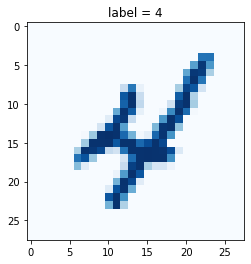

In [98]:
mnist_dataset.plot_image(9)

# 분류기 훈련시키기

In [99]:
%%time

# 신경망 생성
C = Classifier()

# MNIST 데이터에 대해 훈련 진행
epochs = 3
for i in range(epochs):
  print('training epoch', i+1, "of", epochs)
  for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)
    pass
  pass

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 5min 41s, sys: 5.86 s, total: 5min 47s
Wall time: 2min 53s


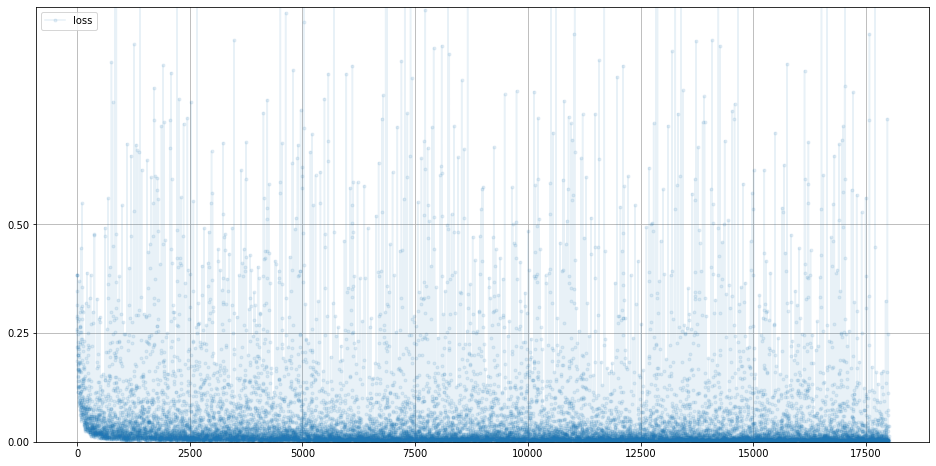

In [100]:
# 분류기 오차 출력
C.plot_progress()

# 신경망에 쿼리하기

In [101]:
# MNIST 테스트 데이터 로드
mnist_test_dataset = MnistDataset('/content/mnist_test.csv')

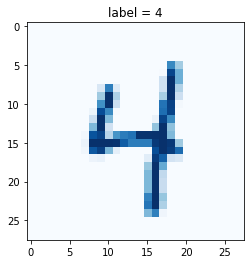

In [102]:
# 레코드 설정
record = 19

# 이미지와 정답 출력
mnist_test_dataset.plot_image(record)

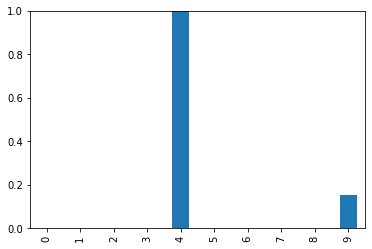

In [103]:
image_data = mnist_test_dataset[record][1]

# 훈련된 신경망으로부터 쿼리
output = C.forward(image_data)

# 텐서 출력
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

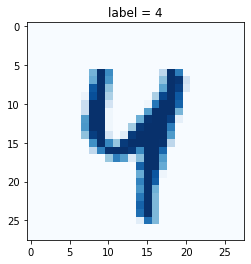

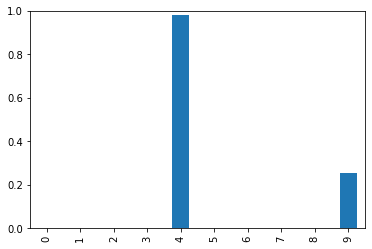

In [104]:
# 애매한 이미지

record = 42

# 이미지와 정답 출력
mnist_test_dataset.plot_image(record)

image_data = mnist_test_dataset[record][1]

# 훈련된 신경망으로부터 쿼리
output = C.forward(image_data)

# 텐서 출력
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

# 분류기의 성능

In [105]:
# 훈련된 신경망을 테스트 데이터셋에 대해 테스트
# 아무것도 안함: 0.87
# BCE로 변경: 0.9028
# LeakyReLu로 변경: 0.9484
# MSE, Adam: 0.9638
# 레이어 정규화: 0.9248

score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
  answer = C.forward(image_data_tensor).detach().numpy()
  if (answer.argmax() == label):
    score += 1
    pass
  items += 1

  pass

print(score, items, score/items)

9248 10000 0.9248
